# WSI 6

Artur Kempiński

Oliwier Szypczyn

In [15]:
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score
from matplotlib import pyplot as plt
import random

# Przygotowywanie i formatowanie danych

In [16]:
def prepare_data(path : str, random_state=random.randint(1, 10000)) -> tuple:
    files = glob.glob(f'{path}/data-*')
    scaler = MinMaxScaler()
    aggregated_data = pd.DataFrame()

    for file in files:
        current_data = pd.read_csv(file, delimiter='\t', header=None, names=['Date', 'Time', 'Type', 'Insulin'])
        aggregated_data = pd.concat([aggregated_data, current_data])

    aggregated_data = aggregated_data[['Date', 'Time', 'Insulin', 'Type']]

    columns_to_normalize = ['Insulin', 'Time', 'Date']
    aggregated_data['Insulin'] = aggregated_data['Insulin'].replace(["0Hi", "0Lo", "0''"], 0.0)
    aggregated_data['Time'] = pd.to_datetime(aggregated_data['Time'], format='%H:%M', errors='coerce').dt.time
    aggregated_data['Time'] = aggregated_data['Time'].apply(lambda x: x.hour * 60 + x.minute)
    aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'], format='%m-%d-%Y', errors='coerce')
    aggregated_data['Date'] = aggregated_data['Date'].dt.dayofyear
    aggregated_data = aggregated_data.dropna()

    aggregated_data[columns_to_normalize] = scaler.fit_transform(aggregated_data[columns_to_normalize])

    aggregated_data = pd.get_dummies(aggregated_data, columns=['Type'], dtype=int)

    aggregated_data.to_csv('normalized_data.csv', index=False)

    features = aggregated_data[['Date', 'Time', 'Insulin']].to_numpy()
    headers = aggregated_data.columns.values.tolist()
    labels = aggregated_data[[col for col in headers if col.startswith('Type')]].to_numpy()

    features_train, features_test, labels_train, labels_test = tts(features, labels, test_size=0.2, random_state=random_state)

    result = []
    for dataset in (features_train, features_test, labels_train, labels_test):
        temp = []
        for row in dataset:
            temp.append([row])
        result.append(np.array(temp))

    return tuple(result)

# Implementacja

In [17]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = self._mse
        self.loss_prime = self._mse_prime

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = self._propagate_layers_forward(input_data[i])
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate, draw_plot=False, print_epoch=False):
        samples = len(x_train)
        data = []
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = self._propagate_layers_forward(x_train[j])

                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                self._propagate_layers_backward(error, learning_rate)

            err /= samples
            data.append(err)

            if print_epoch:
                print(f'epoch {i+1}/{epochs}\terror={err}')

        if draw_plot:
            plt.plot(data)
            plt.show()

    def _propagate_layers_forward(self, input_data):
        output = input_data
        for layer in self.layers:
            output = layer.forward_propagation(output)
        return output

    def _propagate_layers_backward(self, error, learning_rate):
        for layer in reversed(self.layers):
            error = layer.backward_propagation(error, learning_rate)

    def _mse(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))

    def _mse_prime(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / np.size(y_true)


In [18]:
class Layer:
    def __init__(self, input_size, output_size, activation_f_type = 'sigmoid'):
        self.weights = np.random.uniform(low=-1/np.sqrt(input_size), high=1/np.sqrt(input_size), size=(input_size, output_size))
        self.bias = np.random.rand(1, output_size) - 0.5
        self.activation, self.activation_prime = self._get_activation_f(activation_f_type)

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.activation(self.output)

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error

        return self.activation_prime(self.input) * input_error

    def _get_activation_f(self, activation_f_type):
        if activation_f_type == 'sigmoid':
            return self._sigmoid, self._sigmoid_prime
        elif activation_f_type == 'tanh':
            return self._tanh, self._tanh_prime
        elif activation_f_type == 'relu':
            return self._relu, self._relu_prime
        else:
            raise Exception('Activation function not supported')

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_prime(self, x):
        return np.where(x > 0, 1, 0)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_prime(self, x):
        return x * (1 - x)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_prime(self, x):
        return 1 - x * x

In [19]:
def parse_result(result):
    output = []
    for row in result:
        output.append(np.argmax(row))
    return np.array(output)

# Analiza

In [20]:
x_train, x_test, y_train, y_test = prepare_data('Diabetes-Data')

Pierwszy wykres służy odnalezieniu dobrej liczby epok do dalszego trenowania.

Zdecydowaliśmy, że 200 epok będzie wystarczające aby osiągnać dobre wyniki w rozsądnym czasie

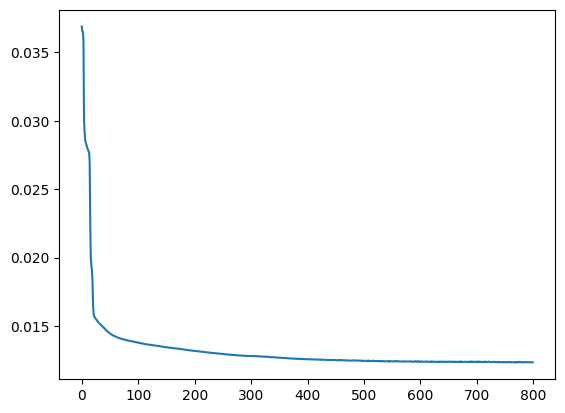

0.8031105793881388


In [21]:
net = Network()
net.add(Layer(3, 10, 'sigmoid'))
net.add(Layer(10, 15, 'sigmoid'))
net.add(Layer(15, 10, 'sigmoid'))
net.add(Layer(10, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=800, learning_rate=0.2, draw_plot=True)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

Poniżej przeanalizowaliśmy kilka wybranych struktur sieci, do dalszych testów wybraliśmy wariant drugi

In [23]:
net = Network()
net.add(Layer(3, 10, 'sigmoid'))
net.add(Layer(10, 15, 'sigmoid'))
net.add(Layer(15, 10, 'sigmoid'))
net.add(Layer(10, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.78260126474107


In [24]:
net = Network()
net.add(Layer(3, 7, 'sigmoid'))
net.add(Layer(7, 15, 'sigmoid'))
net.add(Layer(15, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.794735942573919


In [26]:
net = Network()
net.add(Layer(3, 10, 'sigmoid'))
net.add(Layer(10, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.7680738335327294


Z wykorzystaniem poprzednio wybranej struktury sieci przetestowaliśmy róźne funkcje aktywacji

In [27]:
net = Network()
net.add(Layer(3, 7, 'sigmoid'))
net.add(Layer(7, 15, 'sigmoid'))
net.add(Layer(15, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.8017432917450008


In [28]:
net = Network()
net.add(Layer(3, 7, 'relu'))
net.add(Layer(7, 15, 'relu'))
net.add(Layer(15, 23, 'relu'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

Accuracy:  0.7795248675440096


In [29]:
net = Network()
net.add(Layer(3, 7, 'tanh'))
net.add(Layer(7, 15, 'tanh'))
net.add(Layer(15, 23, 'tanh'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

Accuracy:  0.775593915569988
